## PSM Comparison
**The purpose of this notebook is to process public service motivaiton (PSM) data from different studies in the literature, and data from PSM-related items in the International Social Survey Programme (ISSP) (a cross-national survey).  Once the data is processed, they will be used to create plots to compare PSM across and within countries.  These plots will be used in a book project.**

In [389]:
'''data'''
import pandas as pd
import numpy as np
from scipy import stats
import re

'''plots'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

'''modelling'''
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


**Import data**

In [390]:
studies = pd.read_csv("data/psm_studies_data.csv")
oecd_category = pd.read_csv("data/oecd_classification.csv")
issp = pd.read_csv("data/issp_2014.csv")
cpi_2014 = pd.read_csv("data/cpi_2014.csv")

**Process data**

**Items that we need from the ISSP 2014 data (I only exported these items from "issp2014.dta" to "issp2014.csv"** 
- Attraction to public policymaking 
    - Q4 (V8): To what extent do you consider this to be important: To keep watch on the actions of government
    - Q5 (V9): To waht extent do you consider this to be important: To be active in social or political associations

- Compassion
    - Q8 (V12): To what extent do you consider this to be important: To help people in COUNTRY who are worse off than yourself
    - Q9 (V13): To what extent do you consider this to be important: To help people in the rest of the world who are worse off than yourself

- Self-sacrifice
    - Q7 (V11): To what extent do you consider this to be important: To choose products for political, ethnical, or environmental reasons, even if they cost a bit more.

- Countries
    - C_ALPHAN: Country Prefix code 
    - V4: Country
  
- Employer type
    - TYPORG2: Do/did you worked for a public or private employer?
    
- Age
    - AGE: Age of teh respondent 
    
- Sex
    - SEX: Sex of the respondent
    
- Years of schooling
    - EDUCYRS: How many full years of schooling or education have you had? Please include primary and secondary schooling, university and full-time vocational training, but do not include repeated years.

- CPI 2014
    - Corruption Perception Index
    

In [391]:
issp.rename(columns={'V4':'country_name','TYPORG2':'employee_type',
                     'SEX':'sex', 'AGE':'age', "EDUCYRS":'education',
                    'V8':'politics_1', 'V9':'politics_2',
                    'V12':'compassion_1', 'V13':'compassion_2', 
                    'V11':'self_sacrifice'}, inplace=True)

In [392]:
issp["issp"] = 1

In [393]:
issp.head()

,country_name,employee_type,sex,age,education,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,issp
0,AU-Australia,"NAP (code 3 in WORK; GB: code 0,2,3 in EMPREL)",Female,25,16,"7, Very important",5,"7, Very important","7, Very important","7, Very important",1
1,AU-Australia,No answer,Male,55,"No answer; NL: NA, above 30 years at school",Can't choose,Can't choose,Can't choose,Can't choose,Can't choose,1
2,AU-Australia,Private employer,Male,40,20,5,4,"7, Very important",5,4,1
3,AU-Australia,Private employer,Female,57,11,No answer,No answer,No answer,No answer,No answer,1
4,AU-Australia,Private employer,Female,32,18,4,4,6,5,3,1


**Look at unique values of each column**

In [394]:
issp.country_name.unique()

array(['AU-Australia', 'AT-Austria', 'CL-Chile', 'TW-Taiwan',
       'HR-Croatia', 'CZ-Czech Republic', 'DK-Denmark', 'FI-Finland',
       'FR-France', 'GE-Georgia', 'HU-Hungary', 'IS-Iceland', 'IN-India',
       'JP-Japan', 'KR-Korea (South)', 'LT-Lithuania', 'NL-Netherlands',
       'NO-Norway', 'PH-Philippines', 'PL-Poland', 'RU-Russia',
       'SK-Slovak Republic', 'SI-Slovenia', 'ZA-South Africa', 'ES-Spain',
       'SE-Sweden', 'CH-Switzerland', 'TR-Turkey', 'US-United States',
       'VE-Venezuela', 'BE-Belgium', 'DE-Germany', 'IL-Israel',
       'GB-GBN-Great Britain and/or United Kingdom'], dtype=object)

In [395]:
issp.employee_type.unique()

array(['NAP (code 3 in WORK; GB: code 0,2,3 in EMPREL)', 'No answer',
       'Private employer', 'Public employer', "Don't know"], dtype=object)

In [396]:
issp.sex.unique()

array(['Female', 'Male', 'No answer'], dtype=object)

In [397]:
issp.age.unique()

array(['25', '55', '40', '57', '32', '24', '67', '39', '41', '36', '35',
       '45', '79', '51', '62', '47', '60', '59', '48', '95', '37', '75',
       '72', '34', '80', '54', '20', '56', '42', '31', '44', '26', '29',
       'No answer', '66', '58', '50', '68', '85', '69', '70', '74', '71',
       '63', '64', '83', '61', '52', '90', '19', '43', '49', '53', '65',
       '23', '76', '30', '38', '46', '73', '33', '77', '27', '78', '86',
       '28', '89', '81', '22', '87', '84', '82', '88', '21', '91', '93',
       '92', '16', '18', '94', '17', '97', '15 years', '99', '98',
       '102 years', '101', '96'], dtype=object)

In [398]:
issp.employee_type.unique()

array(['NAP (code 3 in WORK; GB: code 0,2,3 in EMPREL)', 'No answer',
       'Private employer', 'Public employer', "Don't know"], dtype=object)

In [399]:
issp.education.unique()

array(['16', 'No answer; NL: NA, above 30 years at school', '20', '11',
       '18', '17', '15', '12', '8', '25', '14', '19', '9', '24', '10',
       '7', '13', '6', '22', '21', '26', '30', '5', '23', '4', '3',
       '1 year', '2', 'No formal schooling, no years at school',
       "Don't know", '27', '65', '63', '51', '42', '40', '48', '36', '31',
       '32', '55', '58', '39', '45', '35', '46', '38', '60', '50', '61',
       '68', '44', '37', '56', '43', '49', '59', '33', '54', '28', '41',
       '34', '29', '47', '83 years', 'Not available (HU)',
       'GB: still at college/ university', 'GB: still at school'],
      dtype=object)

**Replace all 'NAP (code 3 in WORK; GB: code 0,2,3 in EMPREL)', 
 'No answer', Don't know', 'Can't choose' with nan**

In [400]:
issp.replace(["NAP (code 3 in WORK; GB: code 0,2,3 in EMPREL)",
             'No answer', "Don't know", "Can't choose",
             "Not available (HU)", "No answer; NL: NA, above 30 years at school", 
             "GB: still at school"],np.nan, inplace=True)

In [401]:
issp.replace(["7, Very important","1, Not at all important",
             "Private employer", "Public employer",
             'GB-GBN-Great Britain and/or United Kingdom', "TW-Taiwan","KR-Korea (South)",
             "1 year","No formal schooling, no years at school","GB: still at college/ university",
             "83 years", "15 years", "102 years"],
             [7,1,"non-bureaucrats", "bureaucrats","GB-United Kingdom","TW-Taiwan, China",
             "KR-Korea, Rep.", 1, 0, 14, 83, 15, 102],inplace=True) # more replacements

In [402]:
issp.sex.unique()

array(['Female', 'Male', nan], dtype=object)

In [403]:
issp.head()

,country_name,employee_type,sex,age,education,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,issp
0,AU-Australia,NaN,Female,25,16,7,5,7,7,7,1
1,AU-Australia,NaN,Male,55,NaN,NaN,NaN,NaN,NaN,NaN,1
2,AU-Australia,non-bureaucrats,Male,40,20,5,4,7,5,4,1
3,AU-Australia,non-bureaucrats,Female,57,11,NaN,NaN,NaN,NaN,NaN,1
4,AU-Australia,non-bureaucrats,Female,32,18,4,4,6,5,3,1


**Get two letter country code from country name**

In [404]:
issp["country_code_2_ltr"] =  issp["country_name"].map(lambda x: x[:2])

In [405]:
issp["country_code_2_ltr"].unique() 

array(['AU', 'AT', 'CL', 'TW', 'HR', 'CZ', 'DK', 'FI', 'FR', 'GE', 'HU',
       'IS', 'IN', 'JP', 'KR', 'LT', 'NL', 'NO', 'PH', 'PL', 'RU', 'SK',
       'SI', 'ZA', 'ES', 'SE', 'CH', 'TR', 'US', 'VE', 'BE', 'DE', 'IL',
       'GB'], dtype=object)

In [406]:
issp["country_name"].unique() 

array(['AU-Australia', 'AT-Austria', 'CL-Chile', 'TW-Taiwan, China',
       'HR-Croatia', 'CZ-Czech Republic', 'DK-Denmark', 'FI-Finland',
       'FR-France', 'GE-Georgia', 'HU-Hungary', 'IS-Iceland', 'IN-India',
       'JP-Japan', 'KR-Korea, Rep.', 'LT-Lithuania', 'NL-Netherlands',
       'NO-Norway', 'PH-Philippines', 'PL-Poland', 'RU-Russia',
       'SK-Slovak Republic', 'SI-Slovenia', 'ZA-South Africa', 'ES-Spain',
       'SE-Sweden', 'CH-Switzerland', 'TR-Turkey', 'US-United States',
       'VE-Venezuela', 'BE-Belgium', 'DE-Germany', 'IL-Israel',
       'GB-United Kingdom'], dtype=object)

**remove all country code from country name**

In [407]:
issp["country_name"] = issp["country_name"].map(lambda x: re.sub(r'^.*?-','', x))

In [408]:
issp.head()

,country_name,employee_type,sex,age,education,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,issp,country_code_2_ltr
0,Australia,NaN,Female,25,16,7,5,7,7,7,1,AU
1,Australia,NaN,Male,55,NaN,NaN,NaN,NaN,NaN,NaN,1,AU
2,Australia,non-bureaucrats,Male,40,20,5,4,7,5,4,1,AU
3,Australia,non-bureaucrats,Female,57,11,NaN,NaN,NaN,NaN,NaN,1,AU
4,Australia,non-bureaucrats,Female,32,18,4,4,6,5,3,1,AU


In [409]:
issp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49807 entries, 0 to 49806
Data columns (total 12 columns):
country_name          49807 non-null object
employee_type         41952 non-null object
sex                   49783 non-null object
age                   49669 non-null object
education             47578 non-null object
politics_1            47976 non-null object
politics_2            47634 non-null object
compassion_1          48600 non-null object
compassion_2          48118 non-null object
self_sacrifice        47396 non-null object
issp                  49807 non-null int64
country_code_2_ltr    49807 non-null object
dtypes: int64(1), object(11)
memory usage: 4.6+ MB


**Convert all item score, education and age columns into numerics**

In [410]:
issp[["politics_1", "politics_2","compassion_1", "compassion_2", "self_sacrifice", "education", "age"]] = issp[["politics_1", 
                    "politics_2", "compassion_1", "compassion_2", "self_sacrifice", "education", "age"]].apply(pd.to_numeric)

**Convert to 5-point scale**

In [411]:
def scale_likert(cur_val, cur_min, cur_max, new_min, new_max):
    temp1=(cur_val-cur_min)/(cur_max-cur_min) 
    new_val=(new_max-new_min)*temp1 + new_min
    return new_val

In [412]:
issp[["politics_1", "politics_2","compassion_1", "compassion_2", "self_sacrifice"]] = issp[["politics_1", "politics_2",
                            "compassion_1", "compassion_2", "self_sacrifice"]].apply(lambda x: scale_likert(x,1,7,1,5))

In [413]:
issp.sample(5)

,country_name,employee_type,sex,age,education,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,issp,country_code_2_ltr
8033,Czech Republic,non-bureaucrats,Female,63.0,9.0,1.000000,1.000000,5.000000,5.000000,1.000000,1,CZ
14853,Hungary,bureaucrats,Male,73.0,NaN,4.333333,1.000000,5.000000,5.000000,4.333333,1,HU
36574,Spain,non-bureaucrats,Female,31.0,10.0,3.666667,3.666667,2.333333,3.666667,3.000000,1,ES
12767,France,non-bureaucrats,Female,48.0,19.0,2.333333,3.000000,2.333333,4.333333,3.000000,1,FR
28246,Poland,bureaucrats,Female,52.0,17.0,1.000000,4.333333,4.333333,4.333333,1.000000,1,PL


**Examime the columns age and education**

In [414]:
issp[["age","education"]].describe()

,age,education
count,49669.000000,47578.000000
mean,48.070930,12.498255
std,17.651091,4.312553
min,15.000000,0.000000
25%,33.000000,10.000000
50%,48.000000,12.000000
75%,62.000000,15.000000
max,102.000000,83.000000


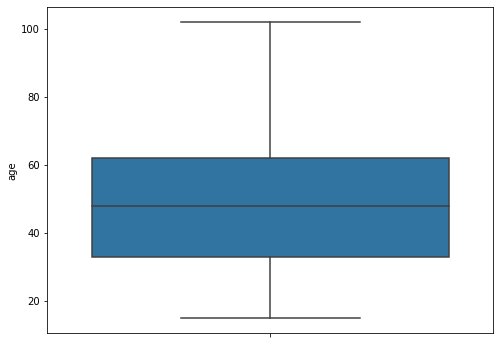

In [415]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y="age", data=issp)

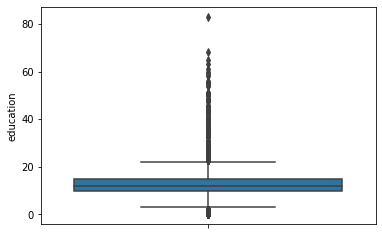

In [416]:
sns.boxplot(y="education", data=issp)

In [417]:
def impute_outliers(df, feature):
    first_quartile = df.loc[:,feature].describe()["25%"]
    third_quartile = df.loc[:,feature].describe()["75%"]
    
    iqr = third_quartile - first_quartile
    lower_bound = first_quartile -3*iqr
    upper_bound = third_quartile+3*iqr
    
    # impute outliers (above upper bound) with np.nan
    df[(df.loc[:,feature]>upper_bound)] = np.nan
    return df

In [418]:
issp = impute_outliers(issp, "education")

In [419]:
# This function aggregate the item scores associated with each feature(take their mean) 
# to get the score for the feature
def aggregate_col (df, feature, items):
    df[feature] = df[items].mean(axis = 1, skipna= True)  # get item means and set it as the feature score
    return df

In [420]:
issp = aggregate_col(issp,"psm", ["politics_1","politics_2","compassion_1","compassion_2","self_sacrifice"])

In [421]:
# remove all rows with psm = nan
issp=issp[issp.psm.notnull()]

**Merge OECD country classifications dataframe with issp dataframe**

In [422]:
sel_list = list(issp.country_name.unique())
oecd_category = oecd_category[oecd_category["country_name"].isin(sel_list)] # only get countries that are in issp data

In [423]:
# merge oecd_category with issp
issp_ind=pd.merge(issp, oecd_category, on='country_name')

**Merge with cpi_2014 dataframe**

In [424]:
cpi_2014 = cpi_2014[cpi_2014["country_name"].isin(sel_list)] # only get countries that are in issp data

In [425]:
# merge cpi 2014 with issp
issp_ind=pd.merge(issp_ind, cpi_2014, on='country_name')

In [426]:
col_order = ["country_name","country_code","country_code_2_ltr","developed","region","employee_type","sex", "age",
             "education", "issp", "politics_1", "politics_2", "compassion_1","compassion_2", "self_sacrifice", "cpi", "psm"]
issp_ind= issp_ind[col_order] # reorder columns

In [427]:
issp_ind.head()

,country_name,country_code,country_code_2_ltr,developed,region,employee_type,sex,age,education,issp,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,cpi,psm
0,Australia,AUS,AU,1,East Asia & Pacific,NaN,Female,25.0,16.0,1.0,5.000000,3.666667,5.000000,5.000000,5.000000,8.0,4.733333
1,Australia,AUS,AU,1,East Asia & Pacific,non-bureaucrats,Male,40.0,20.0,1.0,3.666667,3.000000,5.000000,3.666667,3.000000,8.0,3.666667
2,Australia,AUS,AU,1,East Asia & Pacific,non-bureaucrats,Female,32.0,18.0,1.0,3.000000,3.000000,4.333333,3.666667,2.333333,8.0,3.266667
3,Australia,AUS,AU,1,East Asia & Pacific,non-bureaucrats,Female,24.0,20.0,1.0,3.666667,2.333333,4.333333,3.666667,2.333333,8.0,3.266667
4,Australia,AUS,AU,1,East Asia & Pacific,non-bureaucrats,Male,67.0,18.0,1.0,4.333333,3.666667,4.333333,4.333333,3.000000,8.0,3.933333


In [428]:
# Output processed issp 2014 individual level data
issp_ind.to_csv("outputs/issp2014_ind.csv", index=False)

## Country Level Data

**Group mean (by country and employment type)**

In [429]:
issp_country = issp.groupby(["country_name", "country_code_2_ltr", "employee_type"]).mean()

In [430]:
issp_country.reset_index(level=[0,1,2], inplace=True)

In [431]:
issp_country.head()

,country_name,country_code_2_ltr,employee_type,age,education,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,issp,psm
0,Australia,AU,bureaucrats,54.321429,14.537530,4.274691,3.003101,4.212261,3.550117,3.704137,1.0,3.751826
1,Australia,AU,non-bureaucrats,55.109934,13.504660,4.266413,2.847817,4.197625,3.344887,3.640069,1.0,3.670542
2,Austria,AT,bureaucrats,50.086957,12.596059,3.837438,3.237624,4.069243,3.536585,3.660099,1.0,3.668331
3,Austria,AT,non-bureaucrats,48.741425,11.346720,3.631579,3.059688,4.204958,3.384787,3.485341,1.0,3.558883
4,Belgium,BE,bureaucrats,49.493578,14.329609,3.730939,3.078283,3.902256,3.497132,3.371771,1.0,3.513109


**Merge OECD country classifications and CPI dataframe with issp datafrarme**

In [432]:
# merge wb_category with issp_mean
issp_country=pd.merge(issp_country, oecd_category, on='country_name')
issp_country=pd.merge(issp_country, cpi_2014, on='country_name')

In [433]:
col_order = ["country_name","country_code","country_code_2_ltr","developed","region","employee_type", "age",
             "education", "politics_1", "politics_2", "compassion_1","compassion_2", "self_sacrifice", "issp","cpi", "psm"]
issp_country= issp_country[col_order] # reorder columns

In [434]:
issp_country.head()

,country_name,country_code,country_code_2_ltr,developed,region,employee_type,age,education,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,issp,cpi,psm
0,Australia,AUS,AU,1,East Asia & Pacific,bureaucrats,54.321429,14.537530,4.274691,3.003101,4.212261,3.550117,3.704137,1.0,8.0,3.751826
1,Australia,AUS,AU,1,East Asia & Pacific,non-bureaucrats,55.109934,13.504660,4.266413,2.847817,4.197625,3.344887,3.640069,1.0,8.0,3.670542
2,Austria,AUT,AT,1,Europe & Central Asia,bureaucrats,50.086957,12.596059,3.837438,3.237624,4.069243,3.536585,3.660099,1.0,7.2,3.668331
3,Austria,AUT,AT,1,Europe & Central Asia,non-bureaucrats,48.741425,11.346720,3.631579,3.059688,4.204958,3.384787,3.485341,1.0,7.2,3.558883
4,Belgium,BEL,BE,1,Europe & Central Asia,bureaucrats,49.493578,14.329609,3.730939,3.078283,3.902256,3.497132,3.371771,1.0,7.6,3.513109


In [435]:
# Output processed issp 2014 data
issp_country.to_csv("outputs/issp2014_country.csv", index=False)

**Merge issp data with data from other studies**

In [436]:
df=pd.concat([issp_country,studies], axis=0, sort=False)

In [437]:
# Output processed full data
df.to_csv("outputs/full_psm_processed.csv", index=False)

In [438]:
df.head()

,country_name,country_code,country_code_2_ltr,developed,region,employee_type,age,education,politics_1,politics_2,compassion_1,compassion_2,self_sacrifice,issp,cpi,psm
0,Australia,AUS,AU,1,East Asia & Pacific,bureaucrats,54.321429,14.537530,4.274691,3.003101,4.212261,3.550117,3.704137,1.0,8.0,3.751826
1,Australia,AUS,AU,1,East Asia & Pacific,non-bureaucrats,55.109934,13.504660,4.266413,2.847817,4.197625,3.344887,3.640069,1.0,8.0,3.670542
2,Austria,AUT,AT,1,Europe & Central Asia,bureaucrats,50.086957,12.596059,3.837438,3.237624,4.069243,3.536585,3.660099,1.0,7.2,3.668331
3,Austria,AUT,AT,1,Europe & Central Asia,non-bureaucrats,48.741425,11.346720,3.631579,3.059688,4.204958,3.384787,3.485341,1.0,7.2,3.558883
4,Belgium,BEL,BE,1,Europe & Central Asia,bureaucrats,49.493578,14.329609,3.730939,3.078283,3.902256,3.497132,3.371771,1.0,7.6,3.513109


## Plotting

**1. PSM comparison between developed and developing countries (public employees only)**
    - Boxplots of PSM of developed and developing countries

In [439]:
# data of public employees only
df_public = df[df["employee_type"] =="bureaucrats"]

In [440]:
# Get all the developing countries in the dataframe
# Turn the subset dataframe in to a list of tuples 
developing=df_public.loc[df_public["developed"]==0,["country_code_2_ltr","psm"]]
temp = developing.to_records(index=False)
l_developing=list(temp)

In [441]:
# Get all the developed countries in the dataframe
# Turn the subset dataframe in to a list of tuples 
developed=df_public.loc[df_public["developed"]==1,["country_code_2_ltr","psm"]]
developed.sort_values(by="psm", ascending="False", inplace=True) # sort values by psm
temp = developed.to_records(index=False)
l_developed=list(temp)

In [442]:
len(l_developed)

30

In [443]:
len(l_developing)

17

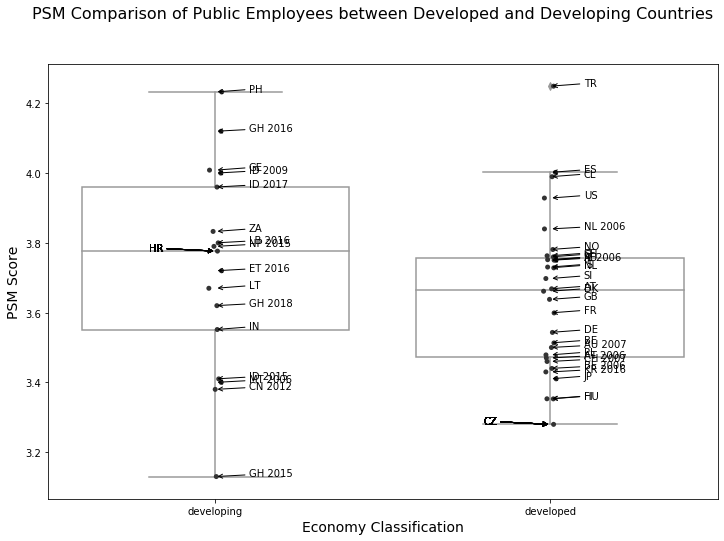

In [444]:
fig = plt.figure(figsize=(12,8))
p1= sns.boxplot(x="developed", y="psm", data=df_public, color='white')
p2 = sns.stripplot(x="developed", y="psm", data=df_public, color=".2", jitter=0.02)


# developing countries annotation
for i in range(1,len(l_developing)):
    p2.annotate(l_developing[i][0], xy=(0,l_developing[i][1]), xytext=(0+0.1,l_developing[i][1]), textcoords='data',
                arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.0"))

    p2.annotate(l_developing[0][0], xy=(0,l_developing[0][1]), xytext=(0-0.2,l_developing[0][1]), textcoords='data',
           arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.0"))


for i in range(1,len(l_developed)):
    p1.annotate(l_developed[i][0], xy=(1,l_developed[i][1]), xytext=(1+0.1,l_developed[i][1]), textcoords='data',
                arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.0"))

    p1.annotate(l_developed[0][0], xy=(1,l_developed[0][1]), xytext=(1-0.2,l_developed[0][1]), textcoords='data',
           arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.0"))


plt.xticks([0,1], ["developing","developed"])
plt.xlabel('Economy Classification', fontsize=14)
plt.ylabel('PSM Score', fontsize=14)
plt.suptitle('PSM Comparison of Public Employees between Developed and Developing Countries', fontsize=16)
plt.show()
fig.savefig('outputs/plots/Develped_vs_Developing.jpeg')

**2. PSM comparison between developed and developing countries (public employees only, without ISSP data)**
    - Boxplots of PSM of developed and developing countries

In [445]:
df_public_noISSP = df_public[df_public["issp"]==0]

In [446]:
# Get all the developing countries in the dataframe
# Turn the subset dataframe in to a list of tuples 
developing=df_public_noISSP.loc[df_public_noISSP["developed"]==0,["country_code_2_ltr","psm"]]
temp = developing.to_records(index=False)
l_developing=list(temp)

In [447]:
# Get all the developed countries in the dataframe
# Turn the subset dataframe in to a list of tuples 
developed=df_public_noISSP.loc[df_public_noISSP["developed"]==1,["country_code_2_ltr","psm"]]
developed.sort_values(by="psm", ascending="False", inplace=True) # sort values by psm
temp = developed.to_records(index=False)
l_developed=list(temp)

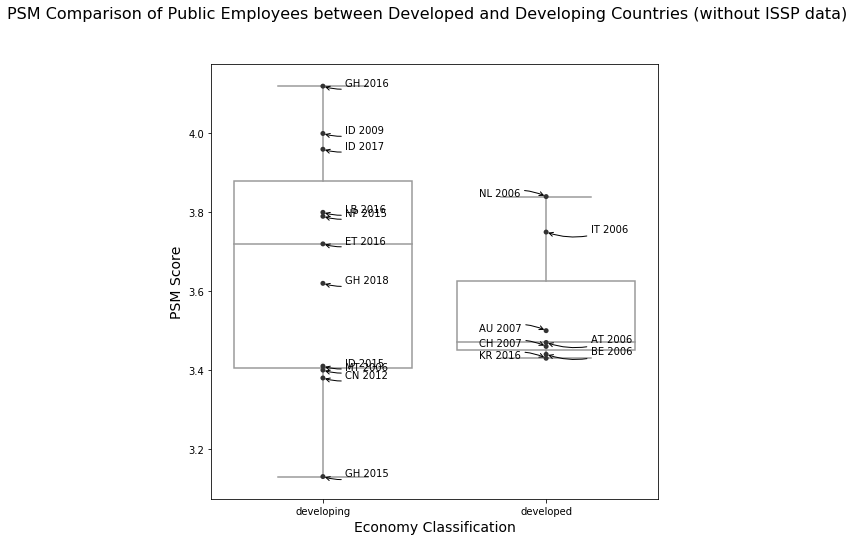

In [448]:
fig = plt.figure(figsize=(8,8))
p1= sns.boxplot(x="developed", y="psm", data=df_public_noISSP, color='white')
p2 = sns.stripplot(x="developed", y="psm", data=df_public_noISSP, color=".2", jitter=0)

# developing countries annotation
for i in range(0,len(l_developing)):
    p2.annotate(l_developing[i][0], xy=(0,l_developing[i][1]), xytext=(0+0.1,l_developing[i][1]), textcoords='data',
                arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.2"))


for i, element in enumerate(l_developed):
    if i % 2 != 0:
        p2.annotate(l_developed[i][0], xy=(1,l_developed[i][1]), xytext=(1+0.2,l_developed[i][1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.2"))

for i, element in enumerate(l_developed):
    if i % 2 == 0:
        p2.annotate(l_developed[i][0], xy=(1,l_developed[i][1]), xytext=(1-0.3,l_developed[i][1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.2"))
        

plt.xticks([0,1], ["developing","developed"])
plt.xlabel('Economy Classification', fontsize=14)
plt.ylabel('PSM Score', fontsize=14)
plt.suptitle('PSM Comparison of Public Employees between Developed and Developing Countries (without ISSP data)', fontsize=16)
plt.show()
fig.savefig('outputs/plots/Develped_vs_Developing_no_ISSP.jpeg')


**3. PSM comparison between employees in public vs private sectors**


In [449]:
df_pub_priv = df.copy()

In [450]:
df_pub_priv.replace(["non-bureaucrats","bureaucrats"], [0,1], inplace=True)

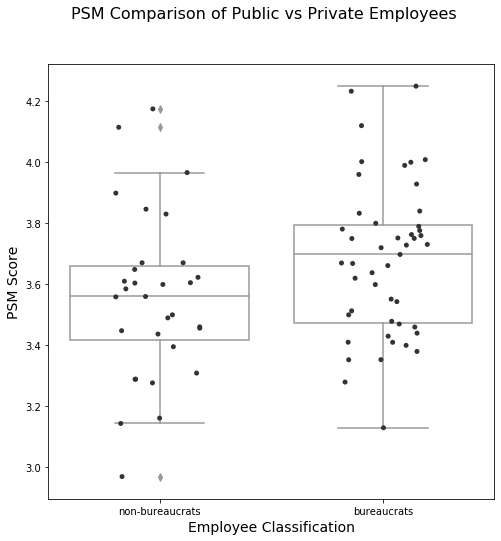

In [451]:
fig = plt.figure(figsize=(8,8))
p1= sns.boxplot(x="employee_type", y="psm", data=df_pub_priv, color='white')
p2 = sns.stripplot(x="employee_type", y="psm", data=df_pub_priv, color=".2", jitter=0.2)


plt.xticks([0,1], ["non-bureaucrats","bureaucrats"])
plt.xlabel('Employee Classification', fontsize=14)
plt.ylabel('PSM Score', fontsize=14)
plt.suptitle('PSM Comparison of Public vs Private Employees', fontsize=16)
plt.show()
fig.savefig('outputs/plots/Public_vs_Private_PSM.jpeg')